In [5]:
import cv2
from PIL import Image, ImageTk
from math import sqrt
import math 
import numpy as np

# Use this resizing to use small images 

In [2]:
im = Image.open("logo.jpg")
print(im.size)
resized = im.resize((1100, 1100), Image.ANTIALIAS)
print(resized.size)
#print(list(resized.getdata()))
resized.show()

(360, 360)
(1100, 1100)


In [3]:
im = cv2.imread("logo.jpg")
print(im.shape)
rs = cv2.resize(im, (24,24))
print(rs.shape)
cv2.imshow('original',im)
cv2.waitKey(0)
cv2.imshow('resized',rs)
cv2.waitKey(0)

(360, 360, 3)
(24, 24, 3)


-1

In [4]:

def getHist(imgPix):
    """
    Return bgr Histograms
    """
    imgPix = np.array(imgPix)
    rbgHist= cv2.calcHist(images=[imgPix], 
                        channels=[0, 1, 2], 
                        mask=None, 
                        histSize=[2, 2, 2], 
                        ranges=[0, 256, 0, 256, 0, 256])

    return rbgHist
rs = cv2.resize(im, (24,24))
h = getHist(rs)
v = h.flatten()
print(h)
print(v)
print(np.reshape(v, (2,2,2)))
np.array(list(map(np.float32, v)))


[[[ 12.   0.]
  [  1.  15.]]

 [[ 39.   0.]
  [  6. 503.]]]
[ 12.   0.   1.  15.  39.   0.   6. 503.]
[[[ 12.   0.]
  [  1.  15.]]

 [[ 39.   0.]
  [  6. 503.]]]


array([ 12.,   0.,   1.,  15.,  39.,   0.,   6., 503.], dtype=float32)

# Color Descriptors

In [5]:

def getAvgs(imgPix):
        """
        la moyenne, moment d’ordre un.
        :return: (avgR, avgG, avgB)
        """
        imgPix = np.array(imgPix)
        height, width, channels = imgPix.shape
        sz = height*width
        t = [0. for _ in range(3)]
        for i in range(len(imgPix)):
            for j in range(len(imgPix[0])):
                t[0] += imgPix[i][j][0]
                t[1] += imgPix[i][j][1]
                t[2] += imgPix[i][j][2]
        t = [y/sz for y in t]
        print('Mean:', imgPix.shape, imgPix.size)
        print(t, "equals")
        
        return list(imgPix.mean(axis=1).mean(axis=0))
    
def getSTDs(imgPix):
        """
        L'écart type, moment d’ordre deux.
        :return:
        """
        imgPix = np.array(imgPix)
        height, width, channels = imgPix.shape
        sz = height*width
        
        mean = getAvgs(imgPix)
        v = [0. for _ in range(3)]
        for i in range(len(imgPix)):
            for j in range(len(imgPix[0])):
                v[0] += (imgPix[i][j][0] - mean[0])**2
                v[1] += (imgPix[i][j][1] - mean[1])**2
                v[2] += (imgPix[i][j][2] - mean[2])**2
        v = [sqrt(y/sz) for y in v]
        print('STD:')
        print(v, "equals")
        return list(imgPix.std(axis=1).std(axis=0))
    
def getMoments(imgPix):
        """
        moment d’ordre trois.
        :return:
        """
        imgPix = np.array(imgPix)
        height, width, channels = imgPix.shape
        sz = height*width
        
        mean = getAvgs(imgPix)
        v = [0. for _ in range(3)]
        for i in range(len(imgPix)):
            for j in range(len(imgPix[0])):
                v[0] += (imgPix[i][j][0] - mean[0])**3
                v[1] += (imgPix[i][j][1] - mean[1])**3
                v[2] += (imgPix[i][j][2] - mean[2])**3
        v = [ abs((y/sz))**(1/3) for y in v]
        features = []
        features.extend(mean)
        features.extend(getSTDs(imgPix))
        features.extend(v)
        return features

In [154]:
print(getAvgs(rs))

Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
[235.69618055555551, 238.1510416666666, 229.22048611111111]


In [155]:
print(getSTDs(rs))

Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
STD:
[45.77348045746132, 42.14232374114895, 66.36832983674661] equals
[25.119248212652426, 25.890382902339375, 42.49990600721883]


In [156]:
print(getMoments(rs))

Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
Mean: (24, 24, 3) 1728
[235.69618055555554, 238.15104166666666, 229.22048611111111] equals
STD:
[45.77348045746132, 42.14232374114895, 66.36832983674661] equals
[235.69618055555551, 238.1510416666666, 229.22048611111111, 25.119248212652426, 25.890382902339375, 42.49990600721883, 61.81698750779069, 56.532930354293505, 90.90555695466534]


# Texture Descriptos

In [1]:
import cv2
from PIL import Image, ImageTk
from math import sqrt
import math 
import numpy as np
from mahotas import features

In [98]:
import matplotlib.pyplot as plt
def getGaborFilterBank(ksize):
    gaborFilters = []
    _lambda = [0.06, 0.09, 0.13, 0.18, 0.25]
    i = 1
    for lnda in _lambda:
        for tta in np.arange(0, np.pi, np.pi / 8):
            kern = cv2.getGaborKernel((ksize, ksize), 3.0, tta, lnda, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            #cv2.imshow('{}'.format(i), kern)
            #cv2.waitKey(0)
            i += 1
            gaborFilters.append(kern)
    return gaborFilters

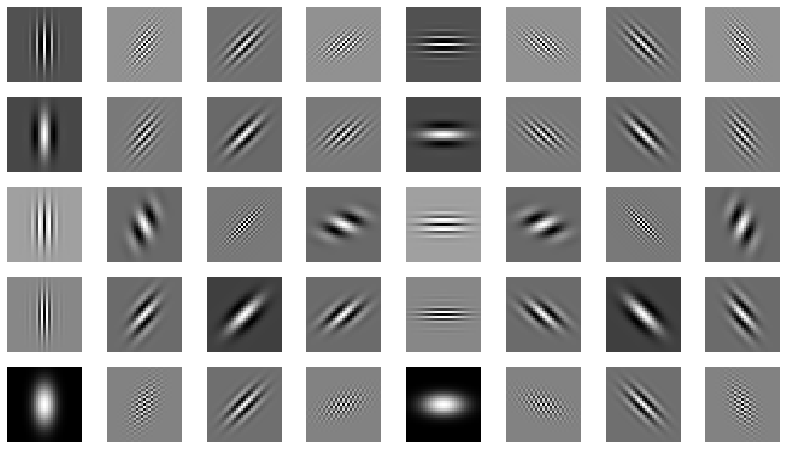

In [99]:
t = getGaborFilterBank(31)

fig=plt.figure(figsize=(14, 8))
columns = 8
rows = 5
for i in range(1, columns*rows +1):
    img = t[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [100]:
def getGaborFeatures(image_file):
        bank = getGaborFilterBank(31)
        image         = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
        #cv2.imshow('{}'.format(i), kernel)
        #cv2.waitKey(0)
        filteredImgs  = []
        features = []
        for kernel in bank:
            filtred = cv2.filter2D(image, cv2.CV_8UC3, kernel)
            filteredImgs.append(filtred)
            features.append(kernel.mean())
            features.append( kernel.std())
            
        #cv2.imwrite("{}.jpg".format(1), filtered_img)
        # convert matrix to vector 
        #descriptor = cv2.resize(filtered_img, (3*width, 3*heigth), interpolation=cv2.INTER_CUBIC)
        
        return filteredImgs, features

[[162 163 163 ... 150 154 172]
 [163 162 164 ... 152 156 171]
 [163 163 163 ... 151 155 170]
 ...
 [162 163 164 ... 152 155 167]
 [163 162 164 ... 156 156 166]
 [163 163 163 ... 154 157 168]]


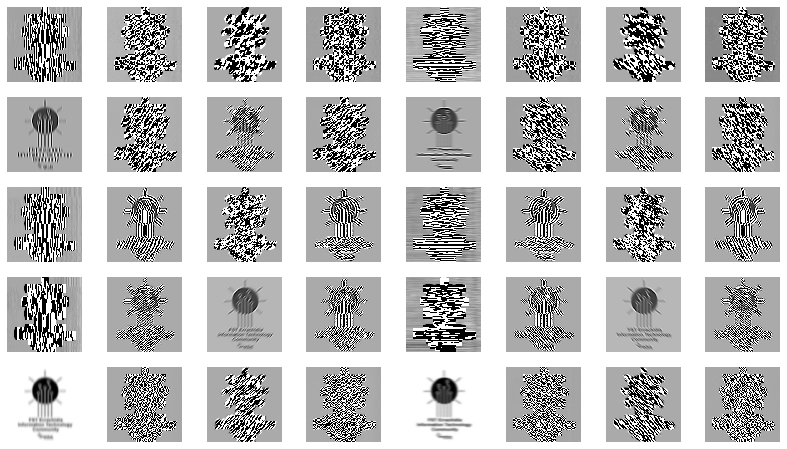

80


In [105]:
t, f = getGaborFeatures("logo.jpg")

fig=plt.figure(figsize=(14, 8))
columns = 8
rows = 5
print(t[0])
for i in range(1, columns*rows +1):
    img = t[(i-1)]
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()
print(len(f))

In [44]:
for i in range(1,9):
    cv2.imshow('{}'.format(i), getGabor("gb.png", i))
    cv2.waitKey(0)

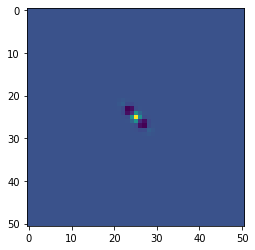

In [61]:
#!/usr/bin/env python
__author__ = "Sreenivas Bhattiprolu"
__license__ = "Feel free to copy, I appreciate if you acknowledge Python for Microscopists"

# https://www.youtube.com/watch?v=QEz4bG9P3Qs


"""
@author: Sreenivas Bhattiprolu
What are features? 
"""

##############################################
#Gabor filter, multiple filters in one. Generate fiter bank. 
"""
For image processing and computer vision, Gabor filters are generally 
used in texture analysis, edge detection, feature extraction, etc. 
Gabor filters are special classes of bandpass filters, i.e., they allow a certain 
‘band’ of frequencies and reject the others.
ksize Size of the filter returned.
sigma Standard deviation of the gaussian envelope.
theta Orientation of the normal to the parallel stripes of a Gabor function.
lambda Wavelength of the sinusoidal factor.
gamma Spatial aspect ratio.
psi Phase offset.
ktype Type of filter coefficients. It can be CV_32F or CV_64F.
indicates the type and range of values that each pixel in the Gabor kernel can hold.
Basically float32 or float64
"""
 
import numpy as np
import cv2
import matplotlib.pyplot as plt

ksize = 51 #Use size that makes sense to the image and fetaure size. Large may not be good. 
#On the synthetic image it is clear how ksize affects imgae (try 5 and 50)
sigma = 2 #Large sigma on small features will fully miss the features. 
theta = 1*np.pi/4  #/4 shows horizontal 3/4 shows other horizontal. Try other contributions
lamda =  5 #1*np.pi /8  #1/4 works best for angled. 
gamma=3  #Value of 1 defines spherical. Calue close to 0 has high aspect ratio
#Value of 1, spherical may not be ideal as it picks up features from other regions.
phi = 0  #Phase offset. I leave it to 0. 


kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv2.CV_32F)

plt.imshow(kernel)


img = cv2.imread('logo.jpg')

#img = cv2.imread('BSE_Image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)

kernel_resized = cv2.resize(kernel, (400, 400))                    # Resize image
cv2.imshow('Kernel', kernel_resized)
cv2.imshow('Original Img.', img)
cv2.imshow('Filtered', fimg)
cv2.waitKey()
cv2.destroyAllWindows()


In [4]:
def getNeighborhood(img, idx, idy, default=0):
    """
    Given the center position to find the position of its neighbors.
    """
    try:
        return img[idx, idy]
    except IndexError:
        return default

def thresholded(center, pixels):
    """
    Compare the center pixel to its 8 neighbors
    """
    ret = []
    for a in pixels:
        if a >= center:
            ret.append(1)
        else:
            ret.append(0)
    return ret

In [6]:
def lbp(img):
    """
    The function for computing Local binary patterns
    img: 
     The numpy ndarray that describe an image.
    """
    height, width = img.shape
    ret = np.empty([height, width], np.uint8)
    for x in range(0, len(img)):
        for y in range(0, len(img[0])):
            center        = img[x,y]
            top_left      = getNeighborhood(img, x-1, y-1)
            top_middle    = getNeighborhood(img, x, y-1)
            top_right     = getNeighborhood(img, x+1, y-1)
            right         = getNeighborhood(img, x+1, y )
            left          = getNeighborhood(img, x-1, y )
            bottom_left   = getNeighborhood(img, x-1, y+1)
            bottom_right  = getNeighborhood(img, x+1, y+1)
            bottom_middle = getNeighborhood(img, x,   y+1)

            values = thresholded(center, [top_left, top_middle, top_right, right, bottom_right,
                                          bottom_middle, bottom_left, left])

            weights = [1, 2, 4, 8, 16, 32, 64, 128]
            res = 0
            for a in range(0, len(values)):
                res += weights[a] * values[a]
            ret.itemset((x,y), res)
    return ret

### Haralick

In [7]:
im = cv2.imread("logo.jpg")
print(im.shape)
rs = cv2.resize(im, (24,24))
print(rs.shape)

(360, 360, 3)
(24, 24, 3)


In [21]:
def getHaralickFeatures(imgPix):
    return list(features.haralick(rs, return_mean=True))

array([ 3.93244805e-01,  2.33844127e+03,  5.74313866e-01,  2.73520367e+03,
        6.54381798e-01,  4.67581168e+02,  8.60237340e+03,  3.53605282e+00,
        4.14069625e+00,  1.55920193e-03,  3.27888113e+00, -4.56807009e-01,
        9.54493673e-01])

In [22]:
features.haralick(rs, return_mean=True)

array([ 3.93244805e-01,  2.33844127e+03,  5.74313866e-01,  2.73520367e+03,
        6.54381798e-01,  4.67581168e+02,  8.60237340e+03,  3.53605282e+00,
        4.14069625e+00,  1.55920193e-03,  3.27888113e+00, -4.56807009e-01,
        9.54493673e-01])

In [23]:
help(features.zernike)

Help on function zernike in module mahotas.features.zernike:

zernike(im, degree, radius, cm=None)
    zvalues = zernike(im, degree, radius, cm={center_of_mass(im)})



# Shape descriptors

### Thresholding: Simple Image Segmentation using OpenCV

In [47]:
import cv2
from PIL import Image, ImageTk
from math import sqrt
import math 
import numpy as np
from mahotas import features

im = cv2.imread("logo.jpg")
print(im.shape)
rs = cv2.resize(im, (24,24))
print(rs.shape)

(360, 360, 3)
(24, 24, 3)


In [44]:
## # load the image and convert it to grayscale
image = cv2.imread('obj.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# initialize the list of threshold methods
methods = [
	("THRESH_BINARY", cv2.THRESH_BINARY),
	("THRESH_BINARY_INV", cv2.THRESH_BINARY_INV),
	("THRESH_TRUNC", cv2.THRESH_TRUNC),
	("THRESH_TOZERO", cv2.THRESH_TOZERO),
	("THRESH_TOZERO_INV", cv2.THRESH_TOZERO_INV)]
# loop over the threshold methods
for (threshName, threshMethod) in methods:
	# threshold the image and show it
	(T, thresh) = cv2.threshold(gray, 50, 255, threshMethod)
	cv2.imshow(threshName, thresh)
	cv2.waitKey(0)

In [48]:
image = cv2.imread('obj.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
(T, thresh) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
cv2.imshow("THRESH_BINARY", thresh)
cv2.waitKey(0)
cv2.HuMoments(cv2.moments(thresh)).flatten()

array([ 7.76684884e-04,  1.93096837e-07,  3.04227311e-12,  2.12171133e-13,
        1.32115500e-25,  4.31682637e-17, -1.07716838e-25])

In [57]:
def getHuMoments(img_file):
    # open image as GrayScale
    gray = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    # Perform a simple segmentation
    (T, thresholded) = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    # return HuMoments
    return cv2.HuMoments(cv2.moments(thresholded)).flatten()

getHuMoments('obj.png')

array([ 7.77101576e-04,  1.93880377e-07,  3.05013893e-12,  2.10576588e-13,
        1.28561598e-25,  4.14296998e-17, -1.09327783e-25])

(360, 360) (360, 360)
(2, 2, 104) 0.01967740079849158


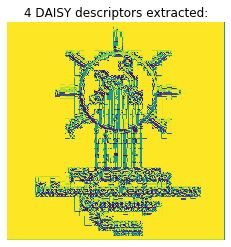

In [44]:
from skimage.feature import daisy
from skimage import data
import matplotlib.pyplot as plt


img = data.horse()
img     = cv2.imread("logo.jpg", cv2.IMREAD_GRAYSCALE)
print(img.shape, lbp(img).shape)
descs, descs_img = daisy(img, step=180, radius=58, rings=2, histograms=6,
                         orientations=8, visualize=True)
print(descs.shape, np.std(descs[0][0]))
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(lbp(img))
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

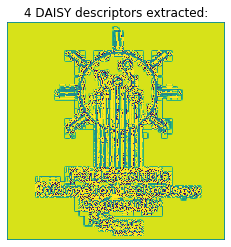

In [45]:
METHOD = 'uniform'
radius = 2
n_points = 8 * radius
from skimage.feature import local_binary_pattern
lbps = local_binary_pattern(img, n_points, radius, METHOD)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(lbps)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)
plt.show()

In [30]:
help(local_binary_pattern)

Help on function local_binary_pattern in module skimage.feature.texture:

local_binary_pattern(image, P, R, method='default')
    Gray scale and rotation invariant LBP (Local Binary Patterns).
    
    LBP is an invariant descriptor that can be used for texture classification.
    
    Parameters
    ----------
    image : (N, M) array
        Graylevel image.
    P : int
        Number of circularly symmetric neighbour set points (quantization of
        the angular space).
    R : float
        Radius of circle (spatial resolution of the operator).
    method : {'default', 'ror', 'uniform', 'var'}
        Method to determine the pattern.
    
        * 'default': original local binary pattern which is gray scale but not
            rotation invariant.
        * 'ror': extension of default implementation which is gray scale and
            rotation invariant.
        * 'uniform': improved rotation invariance with uniform patterns and
            finer quantization of the angular space

In [22]:
17*17*17

4913

In [23]:
26*26

676

In [ ]:
#signature = open(index, 'r')
            '''for line in signature:
                line = line.replace("[", "").replace("]", "").replace("(", "").replace(")", "").split(",")
                filename = line[0]
                avgs = [float(x) for x in line[1:]]
                # TODO: Add to M tree
                self.addObjectsToTree([filename, avgs])
                print(".", end= " ")'''

# Save to desk
            '''
            indexes = open('indexBase.txt', 'w')
            for i in range(len(self.indexBase)):
                indexes.write(str(self.indexBase[i]))
                indexes.write("\n")
            indexes.close()
            '''